In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# reflect the tables
inspector = inspect(engine)

columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c["type"])
    
print('----------------')
    
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [133]:
# Querying the data and collecting the last 12 months of precip data to plot it
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(f'{earliest} {latest}')

import datetime as dt

# Calculate the date from 1 year ago from the last data point in the database
latest_date = dt.datetime.strptime(latest[0], '%Y-%m-%d')
last_12 = (dt.datetime.strptime(latest[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_12

# Query to retrieve the data and precipitation values
last_year_data = session.query(Measurement.date, 
                               Measurement.prcp).\
    filter(Measurement.date >= last_12).all()

last_year_data

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

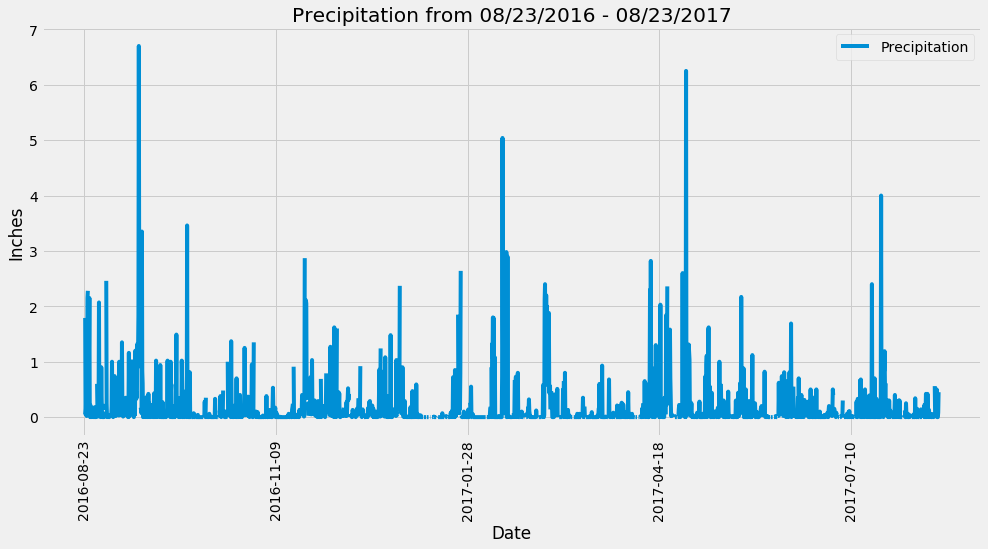

In [134]:
# Save the query results as a Pandas DataFrame
precip_df = pd.DataFrame(last_year_data, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)

# Sorting the dataframe by date
precip_df = precip_df.sort_values(['Date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90, figsize=(15,7))
plt.title('Precipitation from 08/23/2016 - 08/23/2017')
plt.ylabel('Inches')
plt.show()

In [34]:
# Calcualting the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Query for number of stations available in this dataset
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(stations)

9


In [36]:
# Querying to find out which stations are most active
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [37]:
# Calculating the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_stats = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
print(active_stats)

[(54.0, 85.0, 71.66378066378067)]


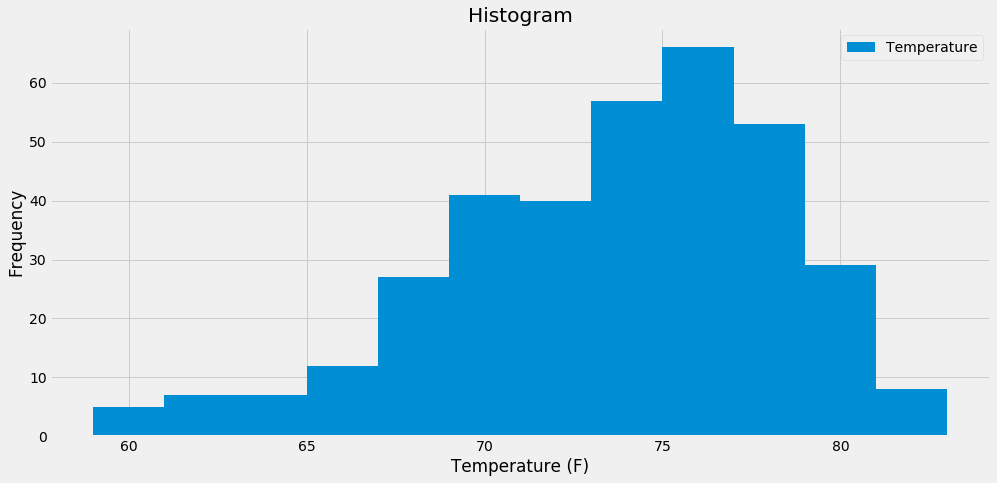

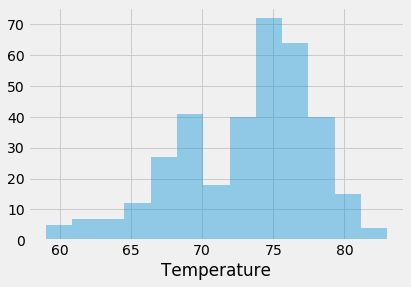

In [62]:
# Querying the last 12 months of temperature observation data for the most active station
sel = [Measurement.station,
       Measurement.date,
       Measurement.tobs]

temp = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_12).all()

temp_df = pd.DataFrame(temp, columns=['Station', 'Date', 'Temperature'])
temp_df.plot(kind='hist', bins=12, figsize=(15,7))
plt.title('Histogram')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

temp_df2 = temp_df['Temperature']
import seaborn as sns
sns.distplot(temp_df2, kde=False)

## Bonus Challenge Assignment

In [63]:
# Creating a function called `calc_temps` that will return the minimum, average, and maximum 
# temperatures for a start and end date
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Using the function on a separate set of dates
trip_avgs = calc_temps('2011-02-28', '2011-03-05')[0]
print(trip_avgs)

(61.0, 69.75510204081633, 75.0)


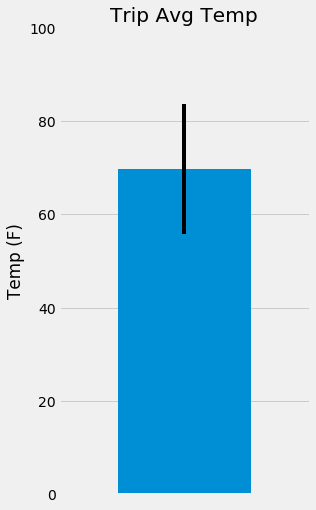

In [82]:
# Plot the results from your previous query as a bar chart.
x=0
y=trip_avgs[1]
y_error=(trip_avgs[2] - trip_avgs[0])

plt.figure(figsize=(4,8))
plt.bar(x, y, yerr=y_error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [357]:
# Calculate the total amount of rainfall per weather station for the trip dates using the previous year's matching dates.
# Sorted in descending order by precipitation amount and listed by the station, name, latitude, longitude, and elevation
start = '2012-02-28' 
end = '2012-03-05'
prev_start = (dt.datetime.strptime(start,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
prev_end = (dt.datetime.strptime(end,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

rainfall = session.query(Station.station,
                         Station.name,
                         Station.latitude,
                         Station.longitude,
                         Station.elevation,
                         func.sum(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= prev_start).filter(Measurement.date <= prev_end).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
 
rainfall_df = pd.DataFrame(rainfall, columns = ['Station', 'Location', 'Lat', 'Lng', 'elevation', 'Total_Rain'])
rainfall_df.set_index('Station', inplace=True)
rainfall_df

,Location,Lat,Lng,elevation,Total_Rain
Station,,,,,
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.74
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.60
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.60
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.46
USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,2.33
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.69
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.41
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.63
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [89]:
# Create a query that will calculate the daily normals 
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [92]:
# calculate the daily normals for any trip dates and
# pushing each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'

start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')

days = []
normals = []

while start <= end:
    days.append(dt.datetime.strftime(start, '%Y-%m-%d'))
    daystr = dt.datetime.strftime(start, '%m-%d')
    normals.append(list(np.ravel(daily_normals(daystr))))
    start = start + dt.timedelta(days=1)
       
normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [105]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns = ['tMin', 'tAvg', 'tMax'], index=days)
trip_df

,tMin,tAvg,tMax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


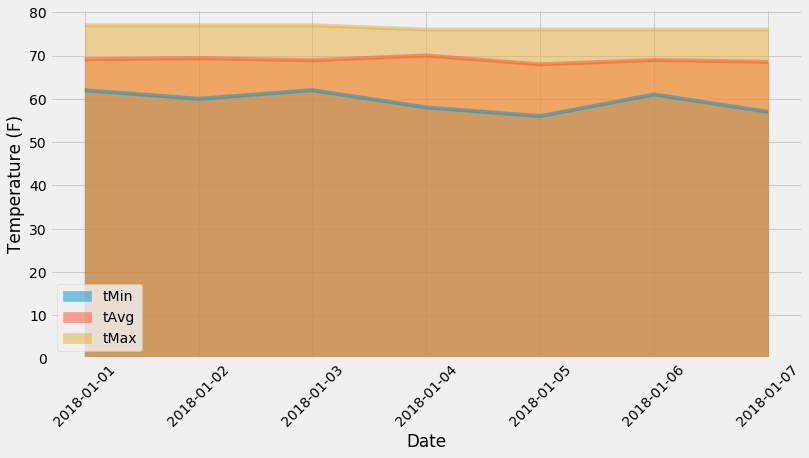

In [106]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, rot=45, figsize=(12,6))
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.show()